# <a id='toc1_'></a>[Исследование посетителей супермаркета](#toc0_)

## <a id='toc1_1_'></a>[Цель](#toc0_)
Провести комплексный многоаспектный анализ данных о посетителях супермаркета с целью выявления скрытых закономерностей в демографических характеристиках, уровне дохода и покупательском поведении. Исследование включает сегментацию клиентов, изучение взаимосвязей между ключевыми переменными (возраст, доход, затраты и пол) и разработку прогностических моделей для поддержки решений в маркетинге и развития клиентской базы.

## <a id='toc1_2_'></a>[Вопросы](#toc0_)
1. На какие сегменты можно разделить клиентов супермаркета с использованием оценки возраста и расходов?
2. Какие зависимости существуют между возрастом, уровнем дохода и тратами клиентов?
3. Как пол влияет на распределение доходов и показателя расходов?
4. Можно ли создать надёжную прогностическую модель для оценки показателя расходов на основе возраста, уровня дохода и пола? Какие факторы являются наиболее значимыми?
5. Какие аномалии и выбросы присутствуют в данных, и как они могут влиять на результаты анализа?

## <a id='toc1_3_'></a>[Описание](#toc0_)
Для проведения исследования был взят следующий набор данных:
https://www.kaggle.com/datasets/vjchoudhary7/customer-segmentation-tutorial-in-python

Есть супермаркет и с помощью членских карт мы получаем некоторые базовые данные о своих клиентах, такие как идентификатор клиента, возраст, пол, годовой доход и рейтинг расходов.
Рейтинг расходов — это показатель, который вы присваиваете клиенту на основе заданных вами параметров, таких как поведение клиента и данные о покупках.

## Содержание:<a id='toc0_'></a>
- [Исследование посетителей супермаркета](#toc1_)
  - [Цель](#toc1_1_)
  - [Вопросы](#toc1_2_)
  - [Описание](#toc1_3_)
- [Обзор данных](#toc2_)
  - [Обзор таблицы](#toc2_1_)
  - [Диагностика данных](#toc2_2_)
- [Визуализация данных](#toc3_)
  - [Диаграммы распределения значений полей](#toc3_1_)
  - [Диаграмма распределения значений по половому признаку](#toc3_2_)
  - [График зависимости годового дохода от возраста](#toc3_3_)
  - [График зависимости показателя расходов от возраста](#toc3_4_)
  - [График зависимости показателя расходов от годового дохода](#toc3_5_)
  - [График распределения годового дохода в зависимости от возраста и пола](#toc3_6_)
  - [График распределения показателя расходов в зависимости от возраста и пола](#toc3_7_)
  - [График распределения показателя расходов в зависимости от годового дохода и пола](#toc3_8_)
- [Вопрос 1. На какие сегменты можно разделить клиентов супермаркета с использованием оценки возраста и расходов?](#toc4_)
  - [Сегментация с использованием оценки возраста и расходов](#toc4_1_)
    - [Разделение посетителей на 3 сегмента](#toc4_1_)
- [Вопрос 2. Какие зависимости существуют между возрастом, доходом и тратами клиентов?](#toc5_)
  - [Корреляционная матрица между возрастом, уровнем годового дохода и показателем расходов](#toc5_1_)
  - [Тепловая карта на основании корреляционной матрицы](#toc5_2_)
- [Вопрос 3. Как пол влияет на распределение доходов и показателя расходов?](#toc6_)
  - [Сводная таблица по половому признаку](#toc6_1_)
  - [Детальная статистика распределения доходов и расходов по половому признаку](#toc6_2_)
  - [Скрипичная диаграмма с распределением доходов по полу](#toc6_3_)
  - [Скрипичная диаграмма с распределением расходов по полу](#toc6_4_)
- [Вопрос 4. Можно ли создать надёжную прогностическую модель для оценки показателя расходов на основе возраста, уровня дохода и пола? Какие факторы являются наиболее значимыми?](#toc7_)
  - [Базовая модель: Линейная регрессия](#toc7_1_)
  - [Сложная модель: Random Forest Regressor](#toc7_2_)
  - [Анализ важности признаков для Random Forest](#toc7_3_)
  - [График для линейной регрессии истинного и предсказанного значения](#toc7_4_)
  - [Дополнительно: Кросс-валидация для оценки устойчивости линейной модели](#toc7_5_)
- [Вопрос 5. Какие аномалии и выбросы присутствуют в данных, и как они могут влиять на результаты анализа?](#toc8_)
  - [Определение выбросов для каждой переменной](#toc8_1_)
- [Итоги](#toc9_)

# <a id='toc2_'></a>[Обзор данных](#toc0_)
Проведём обзор данных с целью понять их структуру и проверить наличие ошибок

Импортируем библиотеки:

In [68]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.offline as pyo
import plotly.io as pio

# графики статические "png" или интерактивные "notebook"
pio.renderers.default = "png"

Чтение данных и определение функции для диагностики df:

In [69]:
# чтение
df = pd.read_csv('data\mall_customers.csv', sep = ',')

# определение функции
def df_diagnostics(df1, target_col=None, iqr_coefficient=1.5):
    # Собираем основные характеристики столбцов
    diag = pd.DataFrame({
        'dtypes': df1.dtypes,
        'count': df1.count(),
        'unique': df1.nunique(),
        'nan_count': df1.isnull().sum(),
        'nan_%': df1.isnull().sum() / df1.shape[0] * 100})

    # Словарь описывающий, какую функцию применить для каждой метрики
    metrics = {
        'mean': lambda s: s.mean(),
        'median': lambda s: s.median(),
        'mode': lambda s: s.mode().iloc[0] if not s.mode().empty else np.nan,
        'std': lambda s: s.std(),
        'min': lambda s: s.min(),
        '25%': lambda s: s.quantile(0.25), # 25% квартиль
        '50%': lambda s: s.quantile(0.50), # 50% квартиль (медиана)
        '75%': lambda s: s.quantile(0.75), # 75% квартиль
        'max': lambda s: s.max()}

    # Вычисляем метрики только для числовых столбцов
    numeric_cols = df1.select_dtypes(include=[np.number]).columns
    for metric, func in metrics.items():
        diag[metric] = [func(df1[col]) if col in numeric_cols else np.nan
                        for col in df1.columns]

    # Подсчёт количества выбросов с регулируемым коэффициентом IQR
    def count_outliers_iqr(col, iqr_coef=iqr_coefficient):
        if pd.api.types.is_numeric_dtype(col) and not pd.api.types.is_bool_dtype(col):
            Q1 = col.quantile(0.25)
            Q3 = col.quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - iqr_coef * IQR
            upper_bound = Q3 + iqr_coef * IQR
            return ((col < lower_bound) | (col > upper_bound)).sum()
        else:
            return np.nan

    # Применяем функцию count_outliers_iqr только к числовым столбцам
    diag['outliers_count'] = [
        count_outliers_iqr(df1[col]) if pd.api.types.is_numeric_dtype(df1[col]) and not pd.api.types.is_bool_dtype(df1[col]) else np.nan
        for col in df1.columns]

    # Количество строк с пропущенными значениями в целевой переменной (если она указана)
    if target_col is not None:
        rows_with_nan_target = df1[target_col].isnull().sum()
        diag['rows_nan_target'] = [rows_with_nan_target] * len(df1.columns)

    # Добавляем корреляцию с целевой переменной (если она указана)
    if target_col is not None and pd.api.types.is_numeric_dtype(df1[target_col]):
        diag['corr_with_target'] = [df1[col].corr(df1[target_col]) if pd.api.types.is_numeric_dtype(df1[col]) else np.nan
                                      for col in df1.columns]

    # Вычисляем количество дублирующих строк в df
    duplicates_count = df1.duplicated().sum()
    print("Количество дублирующих строк:", duplicates_count,
          f"\nOutliers_count: Выбросы в данных более IQR * {iqr_coefficient}")

    # Возвращаем df с градиентной подсветкой, форматированием и округлением чисел
    return (diag.style.background_gradient(cmap='Set3', low=0.1, high=0.01)
            .format("{:.2f}", subset=diag.select_dtypes(include=[np.number]).columns))

## <a id='toc2_1_'></a>[Обзор таблицы](#toc0_)


In [70]:
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


## <a id='toc2_2_'></a>[Диагностика данных](#toc0_)


In [71]:
df_diagnostics(df, target_col='Spending Score (1-100)')

Количество дублирующих строк: 0 
Outliers_count: Выбросы в данных более IQR * 1.5


,dtypes,count,unique,nan_count,nan_%,mean,median,mode,std,min,25%,50%,75%,max,outliers_count,rows_nan_target,corr_with_target
CustomerID,int64,200.00,200.00,0.00,0.00,100.50,100.50,1.00,57.88,1.00,50.75,100.50,150.25,200.00,0.00,0.00,0.01
Gender,object,200.00,2.00,0.00,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00,nan
Age,int64,200.00,51.00,0.00,0.00,38.85,36.00,32.00,13.97,18.00,28.75,36.00,49.00,70.00,0.00,0.00,-0.33
Annual Income (k$),int64,200.00,64.00,0.00,0.00,60.56,61.50,54.00,26.26,15.00,41.50,61.50,78.00,137.00,2.00,0.00,0.01
Spending Score (1-100),int64,200.00,84.00,0.00,0.00,50.20,50.00,42.00,25.82,1.00,34.75,50.00,73.00,99.00,0.00,0.00,1.00


Диагностика данных в таблице показала:
- дублирующих строк нет
- имена полей корректны
- типы данных соответствуют
- все клиенты по полю `CustomerID` уникальные
- пропусков данных в полях нет
- данные о возрасте клиентов `Age` в диапазоне от 18 до 70
- данные о годовом доходе `Annual Income (k$)` в диапазоне от 15 до 137 k$
- данные о показателе расходов `Spending Score (1-100)` в диапазоне от 1 до 99

# <a id='toc3_'></a>[Визуализация данных](#toc0_)

Выполним визуализацию данных для лучшего понимания их структуры

## <a id='toc3_1_'></a>[Диаграммы распределения значений полей](#toc0_)


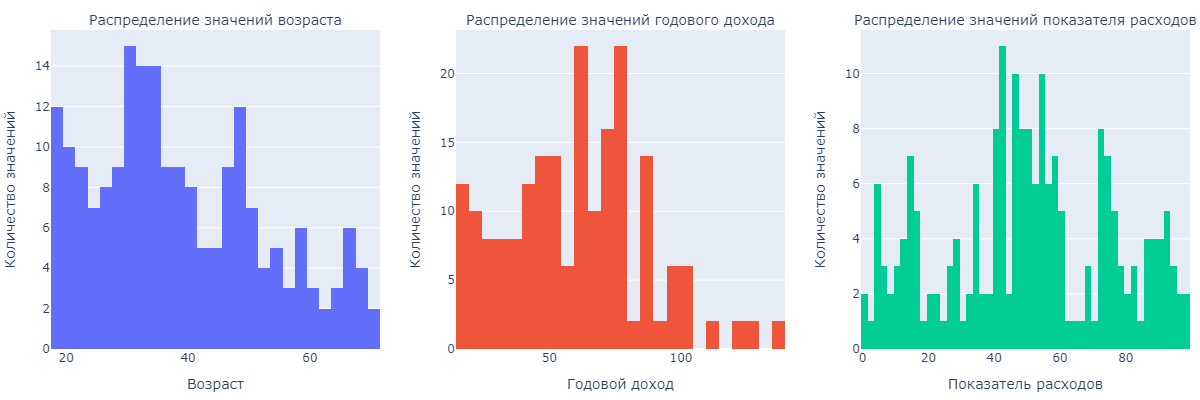

In [72]:
# Создаем subplot с тремя графиками в одной строке
fig = make_subplots(rows=1, cols=3, subplot_titles=("Распределение значений возраста", 
                                                    "Распределение значений годового дохода", 
                                                    "Распределение значений показателя расходов"))

# Добавляем гистограммы для каждого столбца
fig.add_trace(go.Histogram(x=df['Age'], nbinsx=50), row=1, col=1)
fig.add_trace(go.Histogram(x=df['Annual Income (k$)'], nbinsx=50), row=1, col=2)
fig.add_trace(go.Histogram(x=df['Spending Score (1-100)'], nbinsx=50), row=1, col=3)

# Обновляем оси и заголовки
fig.update_xaxes(title_text="Возраст", row=1, col=1)
fig.update_yaxes(title_text="Количество значений", row=1, col=1)

fig.update_xaxes(title_text="Годовой доход", row=1, col=2)
fig.update_yaxes(title_text="Количество значений", row=1, col=2)

fig.update_xaxes(title_text="Показатель расходов", row=1, col=3)
fig.update_yaxes(title_text="Количество значений", row=1, col=3)

fig.update_layout(width=1200, height=400, margin=dict(t=30, b=10, l=10, r=10), showlegend=False,
                  font=dict(size=12), annotations=[dict(font=dict(size=14))])
pyo.iplot(fig)

## <a id='toc3_2_'></a>[Диаграмма распределения значений по половому признаку](#toc0_)


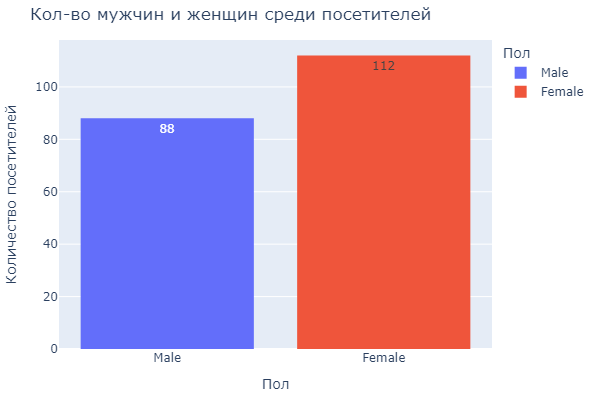

In [73]:
def gender_size():
    fig = px.histogram(df, x="Gender", color='Gender', histfunc='count', text_auto=True,
                    title='Кол-во мужчин и женщин среди посетителей', width=600, height=400,
                    labels={'Gender': 'Пол', 'count': 'Количество значений'})

    fig.update_layout(font=dict(size=12), margin=dict(t=40, b=10, l=10, r=10),
                    yaxis_title="Количество посетителей")
    pyo.iplot(fig)
    
gender_size()

Определим функцию для построения графика распределения:

In [74]:
def scatter_plot(df, x_col, y_col, color_col=None, trendline=None,
                 title=None, x_title=None, y_title=None):
    """Создает scatter plot с использованием Plotly Express"""

    fig = px.scatter(df, x=x_col, y=y_col, color=color_col, trendline=trendline,
                     width=600, height=400, title=title)

    fig.update_layout(font=dict(size=12), margin=dict(t=40, b=10, l=10, r=10),
                      xaxis_title=x_title, yaxis_title=y_title)
    pyo.iplot(fig)
    return None

## <a id='toc3_3_'></a>[График зависимости годового дохода от возраста](#toc0_)


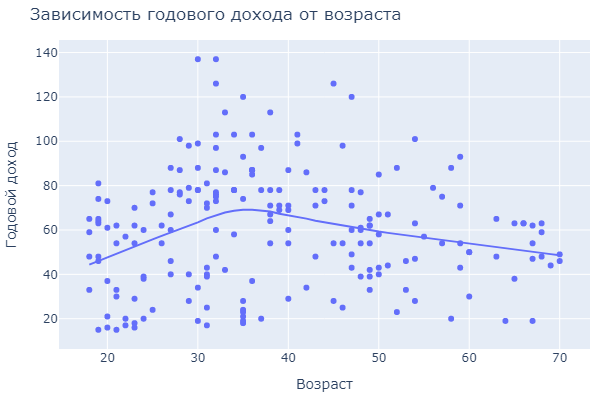

In [75]:
scatter_plot(df, "Age", "Annual Income (k$)", trendline="lowess",
             x_title="Возраст", y_title="Годовой доход",
             title="Зависимость годового дохода от возраста")

## <a id='toc3_4_'></a>[График зависимости показателя расходов от возраста](#toc0_)


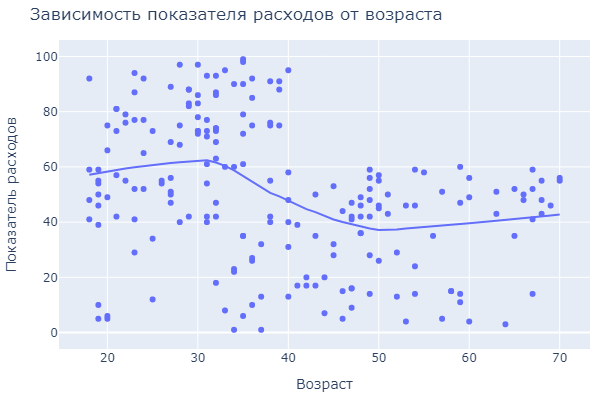

In [76]:
scatter_plot(df, "Age", "Spending Score (1-100)", trendline="lowess",
             x_title="Возраст", y_title="Показатель расходов",
             title="Зависимость показателя расходов от возраста")

## <a id='toc3_5_'></a>[График зависимости показателя расходов от годового дохода](#toc0_)


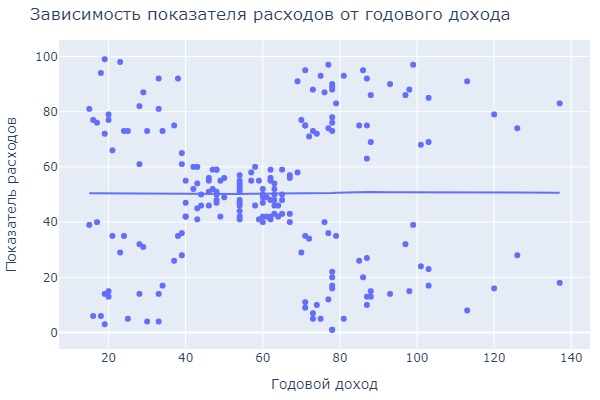

In [77]:
scatter_plot(df, "Annual Income (k$)", "Spending Score (1-100)", trendline="lowess",
             x_title="Годовой доход", y_title="Показатель расходов",
             title="Зависимость показателя расходов от годового дохода")

## <a id='toc3_6_'></a>[График распределения годового дохода в зависимости от возраста и пола](#toc0_)


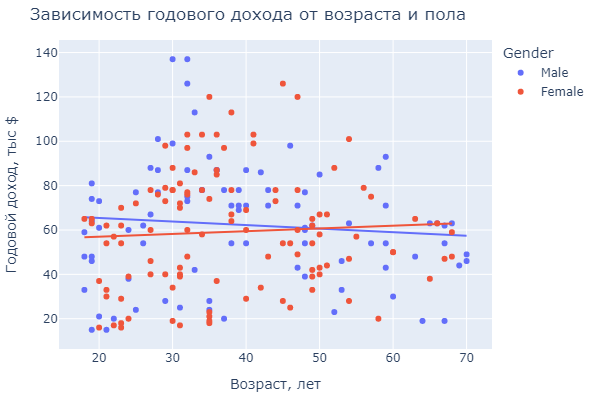

In [78]:
scatter_plot(df, "Age", "Annual Income (k$)", color_col="Gender", trendline="ols",
             x_title="Возраст, лет", y_title="Годовой доход, тыс $",
             title="Зависимость годового дохода от возраста и пола")

Обратим внимание на то, что у женщин годовой доход с увеличением возраста немного увеличивается, а у мужчин немного снижается.

## <a id='toc3_7_'></a>[График распределения показателя расходов в зависимости от возраста и пола](#toc0_)


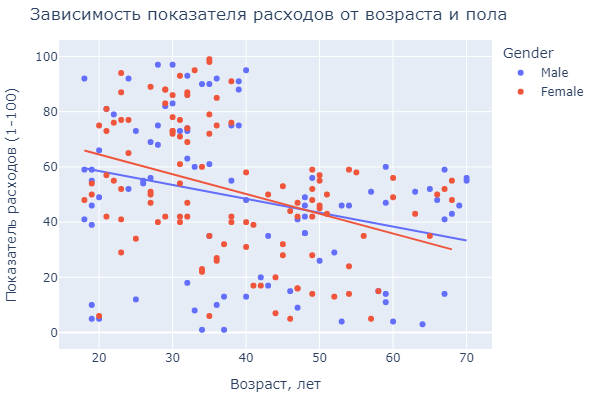

In [79]:
scatter_plot(df, "Age", "Spending Score (1-100)", color_col="Gender", trendline="ols",
             x_title="Возраст, лет", y_title="Показатель расходов (1-100)",
             title="Зависимость показателя расходов от возраста и пола")

Обратим внимание на то, что с увеличением возраста у женщин показатель расходов снижается быстрее.

## <a id='toc3_8_'></a>[График распределения показателя расходов в зависимости от годового дохода и пола](#toc0_)


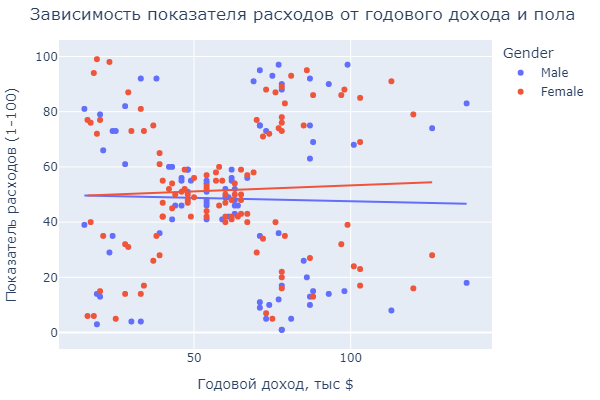

In [80]:
scatter_plot(df, "Annual Income (k$)", "Spending Score (1-100)", color_col="Gender", trendline="ols",
             x_title="Годовой доход, тыс $", y_title="Показатель расходов (1-100)",
             title="Зависимость показателя расходов от годового дохода и пола")

Обратим внимание на то, что с увеличением годового дохода у мужчин показатель расходов незначительно снижается, а у женщин он незначительно растёт.

# <a id='toc4_'></a>[Вопрос 1. На какие сегменты можно разделить клиентов супермаркета с использованием оценки возраста и расходов?](#toc0_)

Для сегментирования клиентов супермаркета выполним разделение клиентов на сегменты с помощью кластеризации методом `К-mean`

Импортируем необходимые библиотеки и внесём определения функций для определения числа кластеров и построения кластеров

In [81]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

def selecting_number_clusters(transf, n_clusters = range(2, 9), init = 'k-means++', n_init = 'auto',
                              tol = 0.0001, max_iter = 300, algorithm = 'lloyd', random_state = None):
    """
    Функция для определения числа кластеров.
    Большинство параметров ретранслируется в метод KMeans() для управления подбора параметров в цикле.
    Определение оптимального числа кластеров происходит путем поиска точки перегиба на графике инерции.
    """

    # если в модель переданы в ручную установленные центроиды, то n_init = 1
    if init not in ['k-means++', 'random']:
        n_init = 1
    
    inertia = []

    for k in n_clusters:
        kmeans = KMeans(n_clusters = k, init = init, n_init = n_init, tol = tol, max_iter = max_iter,
                        algorithm = algorithm, random_state = random_state).fit(transf)
        inertia.append(kmeans.inertia_)

    fig1 = go.Figure()
    fig1.add_trace(go.Scatter(x=list(n_clusters), y=inertia, mode='lines+markers', name='Инерция'))

    fig1.update_layout(title="Зависимость инерции от количества кластеров",
                      xaxis_title="Число кластеров", yaxis_title="Инерция",
                      font=dict(size=12), margin=dict(t=40, b=20, l=20, r=20),
                      width=600, height=400)
    fig1.show()
    return None
    
def building_clusters(df1, column_name, column_label, transf, scaler, n_clusters, init ='k-means++',
                      n_init = 'auto', tol = 0.0001, max_iter = 300, algorithm = 'lloyd',
                      random_state = None, note = None):
    """
    Функция для построения кластеров.
    :param df1: df1 для построения графика.
    :param column_name: список с именами столбцов в df1.
    :param column_label: список как назвать оси на графике.
    :param transf и scaler: для модели сегментации.
    :param note: вывод параметров модели в заголовок графика. Для информирования во время перебора и подбора параметров.
    Остальные параметры перенаправляются в метод KMeans() для управления подбора параметров в цикле.
    """

    # если в модель переданы в ручную установленные центры центроид, то n_init = 1
    if init not in ['k-means++', 'random']:
        n_init = 1

    x_column = column_name[0]
    y_column = column_name[1]
    x_labels = column_label[0]
    y_labels = column_label[1]
    
    # Создаём модель KMeans с кластерами
    kmeans = KMeans(n_clusters = n_clusters, init = init, n_init = n_init, tol = tol, max_iter = max_iter,
                    algorithm = algorithm, random_state = random_state).fit(transf)
    
    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_

    # Переводим центроиды обратно в исходное пространство
    centroids_orig = scaler.inverse_transform(centroids)

    # Создаём сетку в исходном (оригинальном) пространстве
    h = 0.5  # шаг сетки
    x_min = df1[x_column].min() - 1
    x_max = df1[x_column].max() + 1
    y_min = df1[y_column].min() - 1
    y_max = df1[y_column].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Преобразуем сетку в стандартизированное пространство и делаем предсказание
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    grid_points_scaled = scaler.transform(grid_points)
    Z = kmeans.predict(grid_points_scaled)
    Z = Z.reshape(xx.shape)

    # Создаем график
    fig = go.Figure()

    # Добавляем границы кластеров (заливка)
    fig.add_trace(go.Contour(x=np.arange(x_min, x_max, h), y=np.arange(y_min, y_max, h),
                             z=Z, colorscale='tealrose', showscale=False, opacity=0.5))

    # Добавляем исходные данные
    fig.add_trace(go.Scatter(x=df1[x_column], y=df1[y_column], mode='markers',
                             marker=dict(color=labels, colorscale='Viridis',size=6), name='Данные'))

    # Добавляем центроиды
    fig.add_trace(go.Scatter(x=centroids_orig[:, 0], y=centroids_orig[:, 1], mode='markers',
                             marker=dict(color='red', size=12, symbol='x'), name='Центроиды'))

    # Обновляем макет
    title_text = f"Кластеров: {n_clusters}. {note}" if note else f"Разделение посетителей на {n_clusters} кластера"
    fig.update_layout(title=title_text, xaxis_title=x_labels, yaxis_title=y_labels, showlegend=False,
                      width=600, height=400, margin=dict(t=40, b=20, l=20, r=20))
    fig.show()
    return None

## <a id='toc4_1_'></a>[Сегментация с использованием оценки возраста и расходов](#toc0_)

Выполним подготовку данных и выведем график зависимости инерции от количества кластеров

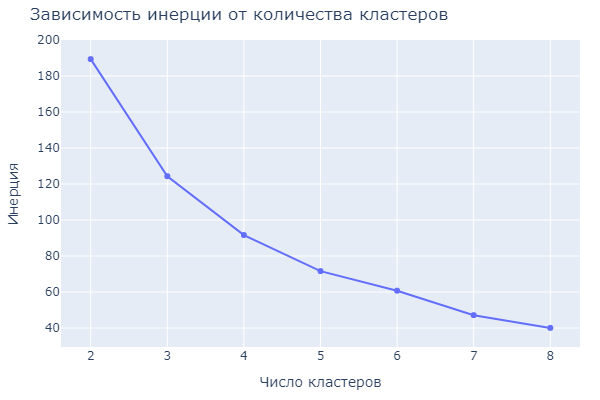

In [82]:
spend_features = df[['Age', 'Spending Score (1-100)']].values
spend_scaler = StandardScaler()
spend_transf = spend_scaler.fit_transform(spend_features)

selecting_number_clusters(transf = spend_transf)

Оптимально разделить посетителей на 3 сегмента. Альтернативно можно разделить также на 4 и 5 сегментов, но в этом случае сегментация даёт сегменты с делением клиентов по показателю расходов на небольшие диапазоны и так стоит делить посетителей только в случае если это оправдано.

### <a id='toc4_1_'></a>[Разделение посетителей на 3 сегмента](#toc0_)


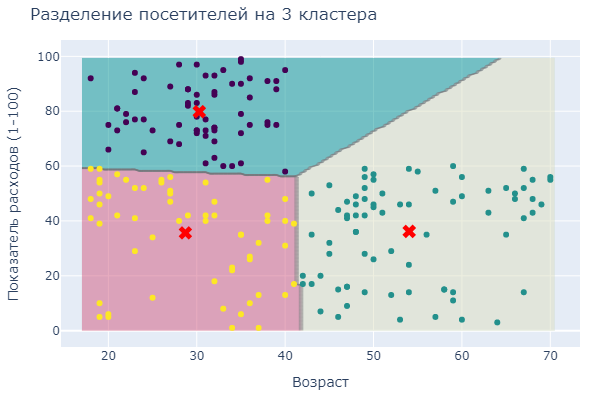

In [83]:
building_clusters(df1= df, column_name = ['Age', 'Spending Score (1-100)'],
                  column_label = ['Возраст', 'Показатель расходов (1-100)'],
                  transf = spend_transf, scaler = spend_scaler, n_clusters = 3, random_state = 34)

Присвоим трём нашим сегментам имена и опишем их:

- Сегмент 1: `Молодые с низким расходом` - Возраст от 0 до 40 лет и показатель расходов от 0 и до 60.

- Сегмент 2: `Молодые с высоким расходом` - Возраст от 0 до 40 лет и показатель расходов от 60 и выше.

- Сегмент 3: `Люди в возрасте` - Возраст от 40 лет и выше и показатель расходов любой.

Зададим каждому посетителю сегмент и для каждого сегмента посчитаем медианные возраст, показатель расходов и доходов и также удельный вес сегмента от общего:

In [84]:
# с помощью логического выражения определим сегмент пользователя и в новый столбец запишем номер сегмента
df['segment'] = df.apply(
    lambda x: 1 if (x['Age'] <= 40) & (x['Spending Score (1-100)'] <= 60) else (
              2 if (x['Age'] <= 40) & (x['Spending Score (1-100)'] > 60) else 3), axis=1)

# сгруппируем посетителей по сегментам и посчитаем для каждого сегмента медианные значения
grouped = df.groupby('segment').agg(
	age = ('Age', 'median'),
	spending = ('Spending Score (1-100)', 'median'),
    annual = ('Annual Income (k$)', 'median'),
    percent = ('CustomerID', lambda x: len(x) / len(df) * 100),
	).reset_index()

# переименуем столбцы df1
grouped.rename(columns={'segment': 'Сегмент', 'age': 'Возраст, лет', 'spending': 'Показатель расходов',
                        'annual': 'Годовой доход, тыс.$', 'percent': 'Удельный вес группы, %'}, inplace=True)

# выведем сгруппированную таблицу
grouped

,Сегмент,"Возраст, лет",Показатель расходов,"Годовой доход, тыс.$","Удельный вес группы, %"
0,1,28.5,41.5,60.0,30.0
1,2,30.5,79.0,73.5,31.0
2,3,51.0,42.0,55.5,39.0


Итоговый вывод по вопросу сформулирован в конце проекта.

# <a id='toc5_'></a>[Вопрос 2. Какие зависимости существуют между возрастом, доходом и тратами клиентов?](#toc0_)

## <a id='toc5_1_'></a>[Корреляционная матрица между возрастом, уровнем годового дохода и показателем расходов](#toc0_)


In [85]:
corr_matrix = df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].corr()
print("Корреляционная матрица:\n", corr_matrix)

Корреляционная матрица:
                              Age  Annual Income (k$)  Spending Score (1-100)
Age                     1.000000           -0.012398               -0.327227
Annual Income (k$)     -0.012398            1.000000                0.009903
Spending Score (1-100) -0.327227            0.009903                1.000000


Расшифровка корреляционной матрицы:
- Возраст (Age) и Годовой Доход (Annual Income):
Коэффициент корреляции равен -0.012398. Это значит, что практически отсутствует какая-либо значимая связь между возрастом и годовым доходом. С увеличением возраста доходы снижаются не значительно.

- Возраст (Age) и Показатель Расходов (Spending Score):
Коэффициент корреляции составляет -0.327227, что свидетельствует о слабой отрицательной зависимости. Это означает, что с увеличением возраста расходы немного снижаются. То есть, чем старше человек, тем ниже его уровень трат.

- Годовой Доход (Annual Income) и Показатель Расходов (Spending Score):
Значение корреляции равно 0.009903, что также указывает на почти полное отсутствие связи. Получается, что увеличение доходов слабо связано с ростом уровня расходов. Люди с большим доходом не обязательно больше тратят.

## <a id='toc5_2_'></a>[Тепловая карта на основании корреляционной матрицы](#toc0_)


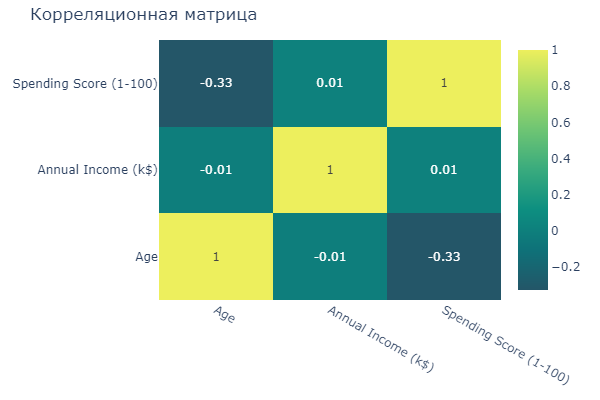

In [86]:
def correl_matrix():
    # Создаем тепловую карту
    fig1 = go.Figure(data=go.Heatmap(z=corr_matrix.values, x=corr_matrix.columns, y=corr_matrix.index,
                                    colorscale='aggrnyl', text=corr_matrix.values.round(2), texttemplate="%{text}"))

    fig1.update_layout(title="Корреляционная матрица", width=600, height=400, margin=dict(t=40, b=20, l=20, r=20))
    fig1.show()

correl_matrix()

# <a id='toc6_'></a>[Вопрос 3. Как пол влияет на распределение доходов и показателя расходов?](#toc0_)

## <a id='toc6_1_'></a>[Сводная таблица по половому признаку](#toc0_)


In [87]:
print("Средние значения `годового дохода` и `показателя расходов` по полу:")
print(df.groupby('Gender')[['Annual Income (k$)', 'Spending Score (1-100)']].mean())

Средние значения `годового дохода` и `показателя расходов` по полу:
        Annual Income (k$)  Spending Score (1-100)
Gender                                            
Female           59.250000               51.526786
Male             62.227273               48.511364


Разъяснение показателей в таблице:
1. Годовой доход:
   - Женщины имеют средний годовой доход около 59,25 тысяч долларов.
   - Мужчины имеют немного больший средний доход — примерно 62,23 тысячи долларов.
   
   Это означает, что мужчины зарабатывают чуть больше, чем женщины, хотя разница невелика.

2. Уровень расходов (по шкале от 1 до 100):
   - Средний уровень расходов среди женщин составляет 51,53.
   - Среди мужчин этот показатель ниже — 48,51.

   Таким образом, женщины тратят немного больше денег, чем мужчины.

## <a id='toc6_2_'></a>[Детальная статистика распределения доходов и расходов по половому признаку](#toc0_)


In [88]:
print("Детальная статистика:")
print(df.groupby('Gender')[['Annual Income (k$)', 'Spending Score (1-100)']].describe())

Детальная статистика:
       Annual Income (k$)                                                  \
                    count       mean        std   min    25%   50%    75%   
Gender                                                                      
Female              112.0  59.250000  26.011952  16.0  39.75  60.0  77.25   
Male                 88.0  62.227273  26.638373  15.0  45.50  62.5  78.00   

              Spending Score (1-100)                                        \
          max                  count       mean       std  min   25%   50%   
Gender                                                                       
Female  126.0                  112.0  51.526786  24.11495  5.0  35.0  50.0   
Male    137.0                   88.0  48.511364  27.89677  1.0  24.5  50.0   

                    
         75%   max  
Gender              
Female  73.0  99.0  
Male    70.0  97.0  


Определим функцию для построения диаграммы скрипичного ключа:


In [89]:
def violin_plot(df, y_col, title=None, x_title=None, y_title=None):
    """Создает violin plot с использованием Plotly Express."""

    fig = px.violin(df, y=y_col, x="Gender", color="Gender", points="all",
                    box=True, title=title, width=600, height=400)

    fig.update_layout(font=dict(size=12), margin=dict(t=40, b=10, l=10, r=10),
                      xaxis_title=x_title, yaxis_title=y_title)
    pyo.iplot(fig)
    return None

## <a id='toc6_3_'></a>[Скрипичная диаграмма с распределением доходов по полу](#toc0_)

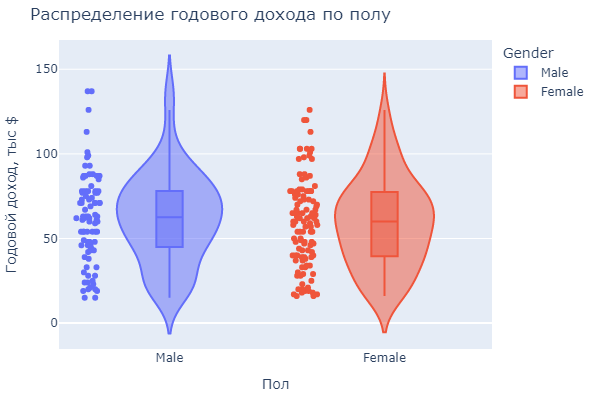

In [90]:
violin_plot(df, y_col="Annual Income (k$)", title="Распределение годового дохода по полу",
            x_title="Пол", y_title="Годовой доход, тыс $")

## <a id='toc6_4_'></a>[Скрипичная диаграмма с распределением расходов по полу](#toc0_)


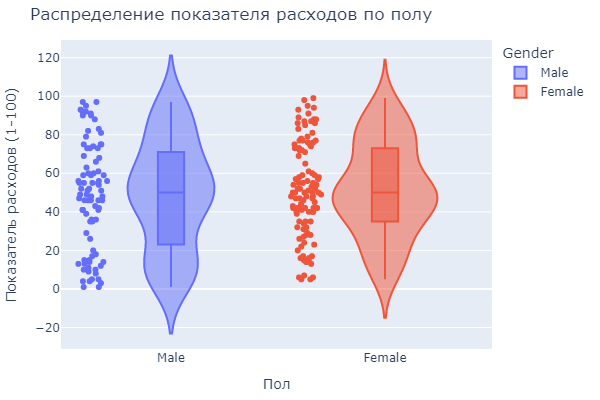

In [91]:
violin_plot(df, y_col="Spending Score (1-100)", title="Распределение показателя расходов по полу",
            x_title="Пол", y_title="Показатель расходов (1-100)")

# <a id='toc7_'></a>[Вопрос 4. Можно ли создать надёжную прогностическую модель для оценки показателя расходов на основе возраста, уровня дохода и пола? Какие факторы являются наиболее значимыми?](#toc0_)

Импортируем необходимые библиотеки и выполним предобработку данных

In [92]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler

# Создание копии DataFrame для моделирования
df_model = df.copy()

# Кодирование переменной Gender
df_model['Gender'] = df_model['Gender'].apply(lambda x: 1 if x == 'Male' else 0)

# Выбор признаков (X) и целевой переменной (y)
X = df_model[['Age', 'Annual Income (k$)', 'Gender']]
y = df_model['Spending Score (1-100)']

# Разбивка на обучающую и тестовую выборки (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Стандартизация признаков для линейной регрессии
scaler_model = StandardScaler()
X_train_scaled = scaler_model.fit_transform(X_train)
X_test_scaled = scaler_model.transform(X_test)

## <a id='toc7_1_'></a>[Базовая модель: Линейная регрессия](#toc0_)


In [93]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)
y_pred_lin = lin_reg.predict(X_test_scaled)

print("Линейная регрессия:")
print("R²:", r2_score(y_test, y_pred_lin))
print("MAE:", mean_absolute_error(y_test, y_pred_lin))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lin)))

Линейная регрессия:
R²: 0.025478181600745997
MAE: 18.151395326685105
RMSE: 21.924259205438346


Показатели модели линейной регрессии указывают на её низкую точность прогнозирования показателя расходов на основе выбранных факторов (возраст, уровень дохода и пол):

- Коэффициент детерминации R²: значение 0.02 означает, что всего лишь около 2% вариации целевой переменной объясняется моделью. Это крайне низкий показатель.
  
- Средняя абсолютная ошибка (MAE) равна примерно 18 единицам шкалы Spending Score. Это значит, что в среднем предсказания отклоняются от реальных значений на 18 пунктов.
  
- Корень среднеквадратичной ошибки (RMSE) составляет почти 22 единицы, что также подтверждает значительную ошибку прогноза.

Модель плохо справляется с задачей — она объясняет менее 2% изменений в расходах клиентов, а её прогнозы часто далеки от истинных значений. Основные признаки, вероятно, недостаточно сильно связаны с целевым показателем.

## <a id='toc7_2_'></a>[Сложная модель: Random Forest Regressor](#toc0_)


In [94]:
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X_train, y_train)
y_pred_rf = rf_reg.predict(X_test)

print("Random Forest Regression:")
print("R²:", r2_score(y_test, y_pred_rf))
print("MAE:", mean_absolute_error(y_test, y_pred_rf))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))

Random Forest Regression:
R²: 0.07749115042457333
MAE: 12.371279166666667
RMSE: 21.331157140778448


Модель случайного леса (Random Forest) показывает немного лучшие результаты по сравнению с линейной регрессией, но всё ещё остаётся недостаточно точной:

- Коэффициент детерминации R²: 0.08 означает, что модель объясняет около 8% вариаций в Spending Score. Хотя это лучше, чем у линейной регрессии, этот результат всё равно считается низким.
  
- Средняя абсолютная ошибка (MAE) уменьшилась до 12 единиц, что говорит о меньшем среднем отклонении прогнозов от фактических значений.
  
- Корень среднеквадратичной ошибки (RMSE) остался практически таким же — около 21 единицы, что свидетельствует о значительной ошибке в прогнозировании.

Случайный лес работает чуть лучше линейной регрессии, уменьшая среднюю ошибку прогноза. Однако модель всё равно остаётся ненадёжной, поскольку она объясняет лишь небольшую долю изменений в показателях расходов.

## <a id='toc7_3_'></a>[Анализ важности признаков для Random Forest](#toc0_)


In [95]:
importances = rf_reg.feature_importances_
feature_names = X.columns

print("Важность признаков (Random Forest):")
for name, importance in zip(feature_names, importances):
    print(f"Признак: {name}, Важность: {importance:.3f}")

Важность признаков (Random Forest):
Признак: Age, Важность: 0.494
Признак: Annual Income (k$), Важность: 0.474
Признак: Gender, Важность: 0.032


Анализ важности признаков для модели случайного леса (Random Forest) показывает вклад каждого признака в предсказание Spending Score:

- Возраст (Age): важность 0.49 указывает, что возраст является самым влиятельным фактором среди всех рассматриваемых признаков. Он оказывает наибольшее влияние на прогнозируемые расходы.
  
- Годовой доход (Annual Income): важность 0.47 также делает его важным признаком, который значительно влияет на прогноз.
  
- Пол (Gender): важность 0.03 демонстрирует, что пол играет наименьшую роль в предсказании расходов, его влияние минимально.

## <a id='toc7_4_'></a>[График для линейной регрессии истинного и предсказанного значения](#toc0_)


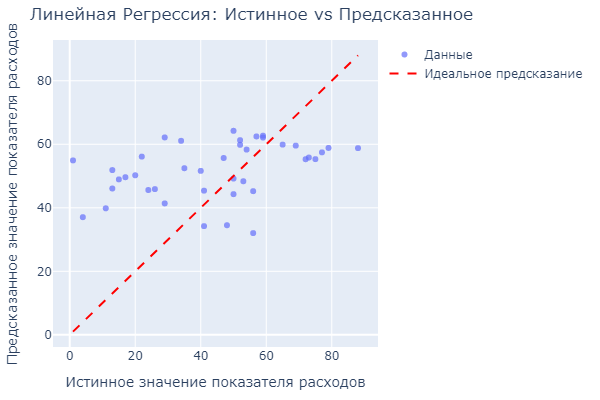

In [96]:
fig = go.Figure()

# Добавляем scatter plot (истинные vs предсказанные значения)
fig.add_trace(go.Scatter(x=y_test, y=y_pred_lin, mode='markers',
                         marker=dict(opacity=0.7), name='Данные'))

# Добавляем линию идеального предсказания (y = x)
fig.add_trace(go.Scatter(x=[min(y_test), max(y_test)], y=[min(y_test), max(y_test)],
                         mode='lines', line=dict(color='red', dash='dash'),
                         name='Идеальное предсказание'))

fig.update_layout(title="Линейная Регрессия: Истинное vs Предсказанное",
                  xaxis_title="Истинное значение показателя расходов",
                  yaxis_title="Предсказанное значение показателя расходов",
                  width=600, height=400, margin=dict(t=40, b=20, l=20, r=20))
fig.show()

График истинного и предсказанного значения отображает соответствие между реальными и предсказанными значениями Spending Score, полученными с помощью модели линейной регрессии. Красная пунктирная линия представляет идеальную ситуацию, когда предсказанные значения точно совпадают с истинными. Если точки плотно сгруппированы вдоль красной линии, это означает высокую точность модели: предсказания близки к реальным значениям.

Интерпретация графика: В нашем случае точки разбросаны далеко от красной линии, что указывает на слабую корреляцию между предсказаниями и реальностью. Значения метрик R², MAE и RMSE это подтверждают.

## <a id='toc7_5_'></a>[Дополнительно: Кросс-валидация для оценки устойчивости линейной модели](#toc0_)


In [97]:
lin_cv_scores = cross_val_score(lin_reg, X_train_scaled, y_train, cv=5, scoring='r2')
print("Кросс-валидация (Линейная регрессия, R²):", lin_cv_scores)

Кросс-валидация (Линейная регрессия, R²): [ 0.14285989 -0.00449044 -0.16108338  0.14920608  0.04561792]


Кросс-валидация используется для оценки устойчивости модели, проверяя её производительность на различных участках данных. В данном случае кросс-валидация была выполнена с использованием 5-кратного разбиения (cv=5), и метрика качества оценивалась через коэффициент детерминации R².

Интерпретация результатов:
- Значение R²: Коэффициент детерминации измеряет долю дисперсии целевой переменной, которую объясняет модель. Значение R² варьируется от 0 до 1, где 1 означает идеальное соответствие модели данным, а 0 — отсутствие связи.
- Устойчивость модели: Важно смотреть на диапазон полученных значений R². Если значения сильно различаются, это может свидетельствовать о нестабильной работе модели на разных частях данных.

# <a id='toc8_'></a>[Вопрос 5. Какие аномалии и выбросы присутствуют в данных, и как они могут влиять на результаты анализа?](#toc0_)

Определим функцию для обнаружения выбросов

In [98]:
def find_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return series[(series < lower_bound) | (series > upper_bound)]

## <a id='toc8_1_'></a>[Определение выбросов для каждой переменной](#toc0_)


In [99]:
outliers_age = find_outliers(df['Age'])
outliers_income = find_outliers(df['Annual Income (k$)'])
outliers_score = find_outliers(df['Spending Score (1-100)'])

# вывод аномалий
print("Аномалии в Age:")
print(outliers_age)
print("\nАномалии в Annual Income:")
print(outliers_income)
print("\nАномалии в Spending Score:")
print(outliers_score)

Аномалии в Age:
Series([], Name: Age, dtype: int64)

Аномалии в Annual Income:
198    137
199    137
Name: Annual Income (k$), dtype: int64

Аномалии в Spending Score:
Series([], Name: Spending Score (1-100), dtype: int64)


Анализ выбросов: Годовой доход (`Annual Income (k$)`): Выбросы были обнаружены в двух наблюдениях с годовым доходом 137 тысяч долларов. Такие значения могут оказаться существенно больше среднего дохода в выборке и, следовательно, представлять собой выбросы, способные повлиять на модели машинного обучения.

Влияние выбросов на результаты анализа:
Выбросы могут оказывать значительное влияние на различные этапы анализа данных, особенно когда речь идет о моделях машинного обучения. Рассмотрим, каким образом выбросы в годовом доходе могут воздействовать на анализ:

1. Регрессии и предсказания:
   - Линейная регрессия и другие методы регрессии чувствительны к выбросам, поскольку они стремятся минимизировать сумму квадратов ошибок между предсказанными значениями и фактическими. Если в данных есть выбросы, такие точки могут смещать линию регрессии, делая её менее точной для основной массы наблюдений.
   - Для моделей типа Random Forest, хотя они и обладают устойчивостью к выбросам благодаря использованию деревьев решений, выбросы всё же могут повлиять на качество модели. Например, если некоторые деревья в случайном лесе будут строить свои решения вокруг выбросов, итоговая оценка будет хуже.

2. Метрики качества:
   - Коэффициент детерминации R² показывает долю дисперсии целевой переменной, которую объясняет модель. Выбросы могут снижать значение R², поскольку они часто находятся далеко от линии регрессии и увеличивают ошибку модели.
   - Средняя абсолютная ошибка (MAE) и среднеквадратичная ошибка (RMSE) также возрастают из-за выбросов, так как эти метрики измеряют разницу между предсказаниями и истинными значениями, включая выбросы.

3. Кросс-валидация:
   Результаты кросс-валидации показывают нестабильность модели линейной регрессии — значения R² варьируются от положительных до отрицательных, что подтверждает чувствительность модели к выбросам. Это может свидетельствовать о переобучении на тренировочном наборе данных.

Рекомендации:
Для повышения точности анализа рекомендуется либо удалить выбросы перед построением моделей, либо использовать робастные алгоритмы, которые менее подвержены влиянию выбросов (например, методы квантильной регрессии). Также стоит учитывать возможное наличие скрытых факторов, объясняющих высокие доходы, чтобы избежать удаления полезной информации.

# <a id='toc9_'></a>[Итоги](#toc0_)


---
**Вопрос 1:** На какие сегменты можно разделить клиентов супермаркета с использованием оценки возраста и расходов?

Клиентов супермаркета на основании оценки возраста и расходов можно разделить на 3 следующих сегмента:

1. Сегмент 1: `Молодые с низким расходом` - В сегмент входят молодые люди до 40 лет с низким уровнем расходов.

2. Сегмент 2: `Молодые с высоким расходом` - В сегмент входят молодые люди до 40 лет с высоким уровнем расходов.

3. Сегмент 3: `Люди в возрасте` - Люди от 40 лет с любым уровнем расходов.

Приведём таблицу с медианными значениями для сегментов возраста, показателя расходов, годового дохода и удельного веса:

In [100]:
grouped

,Сегмент,"Возраст, лет",Показатель расходов,"Годовой доход, тыс.$","Удельный вес группы, %"
0,1,28.5,41.5,60.0,30.0
1,2,30.5,79.0,73.5,31.0
2,3,51.0,42.0,55.5,39.0


---
**Рекомендации:**
 
Фокусировка на сегменте 2: Этот сегмент имеет самый высокий показатель расходов 79 и довольно высокую долю в общем количестве клиентов 31%. Для стимулирования роста покупок у данного сегмента можно предложить следующие меры:
   - Создание персонализированных предложений на основе истории покупок.
   - Проведение акций и распродаж, ориентированных именно на этот сегмент.
   - Введение бонусной программы или системы лояльности для удержания и повышения частоты посещений.
   
Развитие сегмента 1: Хотя средний возраст ниже среднего и составляет 28.5 года, этот сегмент также составляет значительную часть аудитории 30%. Можно попробовать увеличить расходы этой группы через:
   - Продвижение товаров, популярных среди молодежи (например, современные гаджеты, спортивные товары).
   - Интерактивные мероприятия, направленные на привлечение молодых людей (конкурсы, розыгрыши).
   - Расширение ассортимента недорогих продуктов, учитывая относительно низкий годовой доход 60K$.

Повышение активности сегмента 3: Средний возраст в данном сегменте самый высокий и составляет 51 год, и хотя доля этого сегмента велика 39%, расходы ниже среднего 42. Рекомендуется:
   - Акцентирование внимания на продуктах, соответствующих интересам пожилых покупателей (здоровое питание, лекарства).
   - Специальные предложения для пенсионеров, такие как скидки в определенные дни недели.
   - Улучшение удобства шопинга для данной возрастной категории (например, дополнительные места отдыха внутри магазина).

---
**Идеи для дальнейшего анализа:**

1. Анализ корзины покупателя:
   Разделение клиентов по типу приобретаемых товаров поможет лучше понимать потребности каждого сегмента. Например:
   - Выявление основных категорий товаров, покупаемых каждым сегментом.
   - Определение уровня перекрестных продаж между категориями.
   - Поиск возможности расширения ассортимента на основе предпочтений сегментов.

2. Исследование поведенческих паттернов:
   Анализ поведения клиентов внутри магазина позволит выявить ключевые моменты взаимодействия с продуктом и торговой площадкой:
   - Время посещения магазина.
   - Продолжительность пребывания в магазине.
   - Частота покупок.
   - Использование различных каналов покупки (онлайн vs офлайн).

3. Прогнозирование потребительского спроса:
   Построение моделей прогнозирования спроса поможет предугадать поведение клиентов и подготовиться к пиковым нагрузкам:
   - Прогнозирование объемов продаж на ближайшие месяцы/кварталы.
   - Оценка влияния сезонности на покупательское поведение.

4. Создание портретов клиента:
   Более глубокая характеристика каждого сегмента позволит разрабатывать более точные стратегии:
   - Психографические характеристики (интересы, ценности, образ жизни).
   - Социальная активность (использование социальных сетей, участие в общественных мероприятиях).
   - Предпочтительные каналы коммуникации (телефон, email, социальные сети).

---
**Вопрос 2:** Какие зависимости существуют между возрастом, уровнем дохода и тратами клиентов?

- Между возрастом и годовым доходом зависимость практически отсутствует. С увеличением возраста доходы снижаются не значительно.

- Между возрастом и показателем расходов зависимость является слабой отрицательной. Это обозначает, что с увеличением возраста расходы немного снижаются.

- Между годовым доходом и показателем расходов зависимость практически полностью отсутствует. Увеличение расходов слабо связано с ростом уровня доходов. Люди с большим доходом не обязательно больше тратят.

Корреляционная матрица:

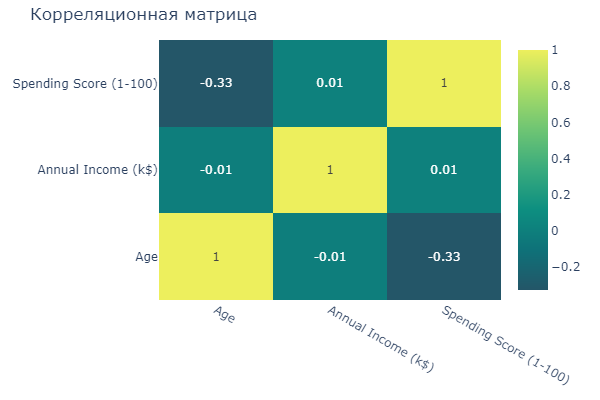

In [101]:
correl_matrix()

График зависимости годового дохода от возраста:

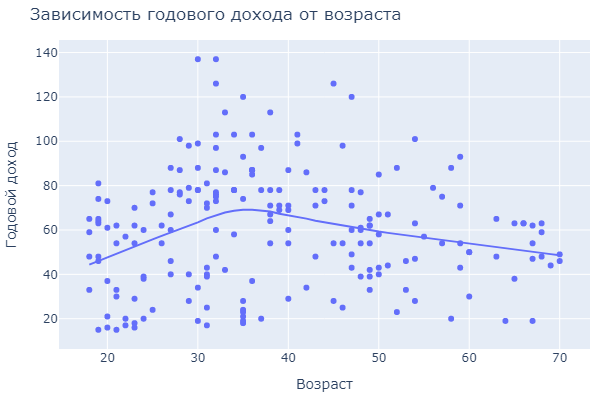

In [102]:
scatter_plot(df, "Age", "Annual Income (k$)", trendline="lowess",
             x_title="Возраст", y_title="Годовой доход",
             title="Зависимость годового дохода от возраста")

График зависимости показателя расходов от возраста:

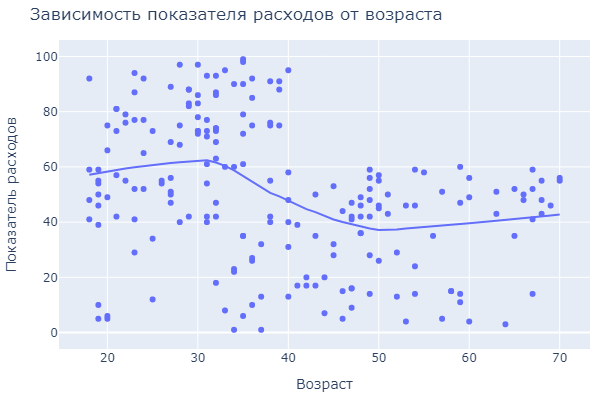

In [103]:
scatter_plot(df, "Age", "Spending Score (1-100)", trendline="lowess",
             x_title="Возраст", y_title="Показатель расходов",
             title="Зависимость показателя расходов от возраста")

График зависимости показателя расходов от годового дохода:

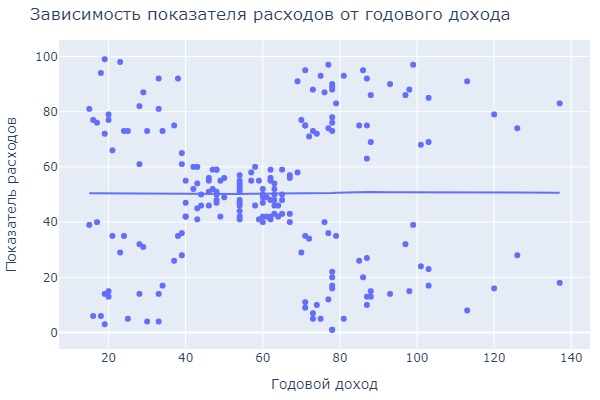

In [104]:
scatter_plot(df, "Annual Income (k$)", "Spending Score (1-100)", trendline="lowess",
             x_title="Годовой доход", y_title="Показатель расходов",
             title="Зависимость показателя расходов от годового дохода")

---
**Вопрос 3:** Как пол влияет на распределение доходов и показателя расходов?

**Влияние пола на годовой доход:** Женщины имеют средний годовой доход около 59,25 тысяч долларов. Мужчины имеют немного больший средний доход — примерно 62,23 тысячи долларов. Это означает, что мужчины зарабатывают чуть больше, чем женщины, хотя разница невелика.

**Влияние пола на показатель расходов:** Средний уровень расходов среди женщин составляет 51,53. Среди мужчин этот показатель ниже — 48,51. Таким образом, женщины тратят немного больше денег, чем мужчины.

**В итоге:** Несмотря на то, что мужчины в среднем зарабатывают больше, женщины склонны тратить больше относительно своего дохода. Это может указывать на различия в покупательских привычках или предпочтениях между полами.

Количество мужчин и женщин в выборке:

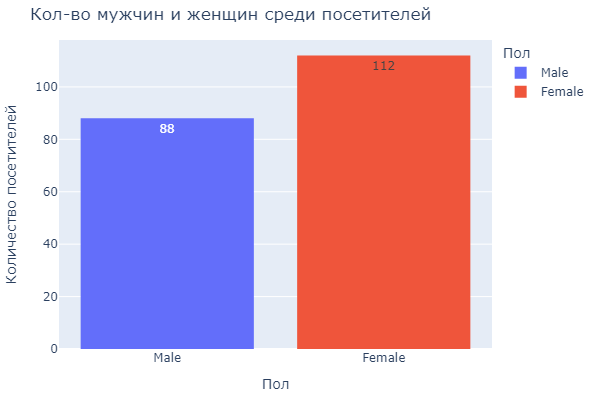

In [105]:
gender_size()

Скрипичная диаграмма с распределением доходов по полу:

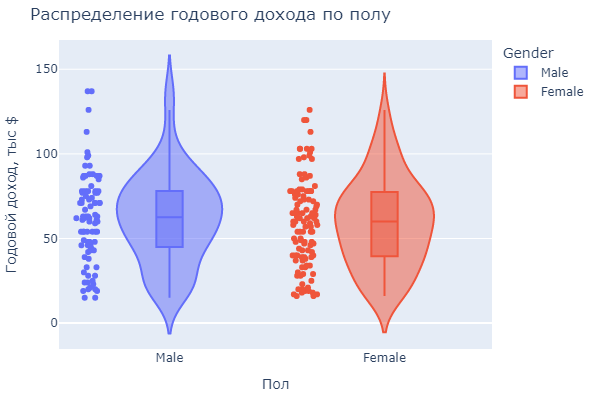

In [106]:
violin_plot(df, y_col="Annual Income (k$)", title="Распределение годового дохода по полу",
            x_title="Пол", y_title="Годовой доход, тыс $")

Скрипичная диаграмма с распределением расходов по полу:

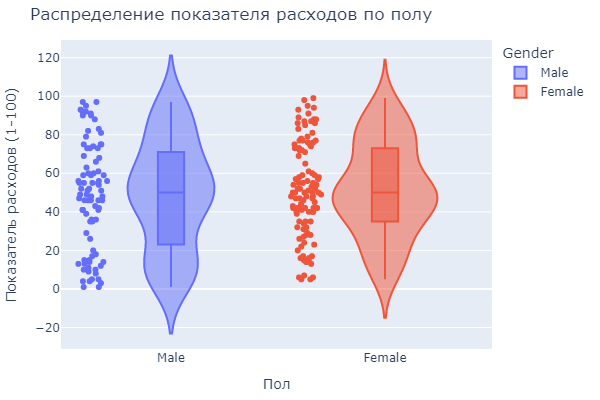

In [107]:
violin_plot(df, y_col="Spending Score (1-100)", title="Распределение показателя расходов по полу",
            x_title="Пол", y_title="Показатель расходов (1-100)")

---
**Вопрос 4:** Можно ли создать надёжную прогностическую модель для оценки показателя расходов на основе возраста, уровня дохода и пола? Какие факторы являются наиболее значимыми?

На основании проведённого анализа нельзя создать надёжную прогностическую модель для оценки показателя расходов исключительно на основе таких факторов, как возраст, уровень дохода и пол. Модель оказывается недостаточно точной для практических целей.

Наиболее значимые факторы, влияющие на прогнозирование показателя расходов:

1. Возраст: самый важный фактор, оказывающий значительное влияние на траты.
2. Годовой доход: также сильно влияет на расходы, хотя чуть меньше, чем возраст.
3. Пол: имеет минимальное влияние на предсказание трат.

**Общий вывод:**
Для улучшения точности модели потребуется включить дополнительные данные и признаки, поскольку выбранные параметры (возраст, доход и пол) недостаточно информативны для точного прогнозирования трат.

---
**Вопрос 5:** Какие аномалии и выбросы присутствуют в данных, и как они могут влиять на результаты анализа?

В данных выявлены выбросы в показателях годового дохода, которые могут искажать результаты анализа. Эти выбросы способны негативно влиять на точность моделей машинного обучения, таких как линейная регрессия и даже более устойчивый метод случайного леса. Чтобы улучшить качество анализа, рекомендуется либо исключить выбросы, либо использовать алгоритмы, которые менее восприимчивы к ним, например, квантильную регрессию.